<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from PIL import Image
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

import torchvision
import torch
from torch.utils.data import DataLoader

In [2]:
pwd

'/content'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
   43554ab..30c7110  main       -> origin/main
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Updating 43554ab..30c7110
Fast-forward
 code/loader.py | 13 +++++++++----
 1 file changed, 9 insertions(+), 4 deletions(-)


In [4]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor, find_bounding_box_coords
from loader import WaldoLoader, resize_image
from model import Waldo_UNet
from training import train_model
from data_augmentation import Sequence, RandomHorizontalFlip, RandomTranslate
from inference import patchify_test_image, reconstruct_image_from_patches

In [5]:
path_dataset_folder = "../dataset"
path_image_folder = "images"
fname_annotation = "annotations.csv"
extension = ".jpg"
ratio_train_dataset = 0.8
int_seed_split = 7109
size_patch = 120
sequence_data_augmentation = Sequence([RandomHorizontalFlip(), RandomTranslate(0.2)], probs=0.6)
size_batch = 16
fname_trained_model = "model.pt"
n_epoch = 200

In [6]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the dataset...".format(len(list_fname_im)))

Found 35 images in the dataset...


In [7]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.tail())

Getting annotations...
   filename  width  height  class  xmin  ymin  xmax  ymax
33  031.jpg   3544    2226  waldo  2202  1501  2257  1560
34  032.jpg   1772    1116  waldo   317   709   346   745
35  033.jpg   1511    1178  waldo   327   922   373   974
36  034.jpg   3566    2257  waldo  3057   873  3101   933
37  035.jpg   1848    1158  waldo   177   840   211   877


In [8]:
print("Saving binary mask from annotations as ground-truth...")
for fname_im in list(df_annotations["filename"].unique()):
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        print("... Ground-truth of: {} ...".format(fname_im))
        df_cur = df_annotations[df_annotations["filename"]==fname_im]
        mask = create_binary_mask(list_bbox_coords=df_cur[["xmin", "ymin", "xmax", "ymax"]].values.tolist(),
                              im_ref_width=df_cur["width"].values.tolist()[0],
                              im_ref_height=df_cur["height"].values.tolist()[0])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...


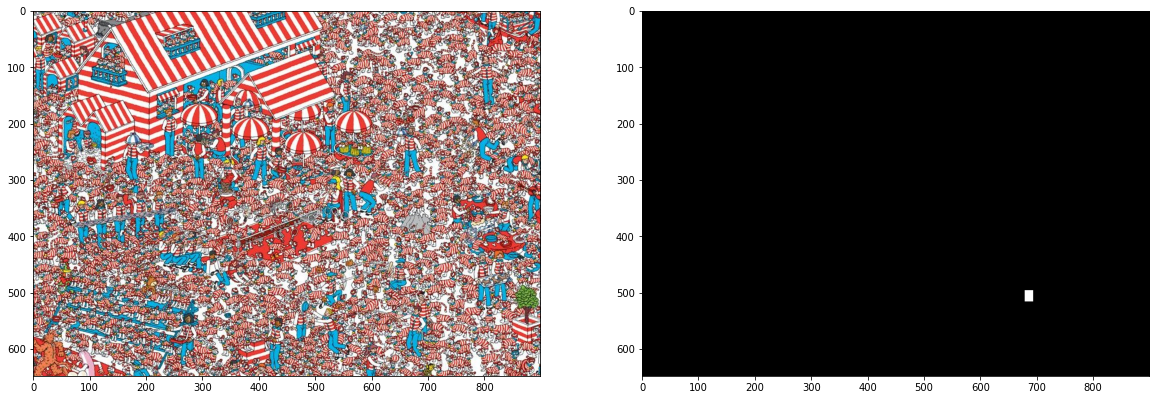

In [9]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))

fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)
plt.imshow(np_gt)

plt.show()

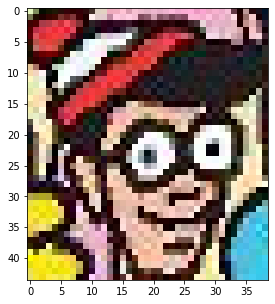

In [10]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png")).convert("L")
np_gt = np.array(gt)
np_gt_labeled, n_waldo = label(np_gt, return_num=True)
fig = plt.figure(figsize=(5, 5))
for i_waldo in range(n_waldo):
    gt_cur = (np_gt_labeled == i_waldo+1).astype(int)
    coords = find_bounding_box_coords(gt_cur)
    plt.subplot(1, n_waldo, i_waldo+1)
    plt.imshow(np_im[coords[0]:coords[1], coords[2]:coords[3]])
plt.show()

In [11]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split), [int(ratio_train_dataset*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554    training
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306  validation
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [23]:
print(len(df_annotations[df_annotations["subset"] == "training"]["filename"].unique()))

28


In [24]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"].unique()
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Loading images ...
Resizing image dimensions so that they are a multiple of the patch size: 120 x 120 pixels^2 ...
(110, 120, 3) (1200, 1800, 3) 1150 744 1139 1162 735 754
hey (120, 120, 3)
(110, 120) (1200, 1800) 1150 744 1139 1162 735 754
hey (120, 120)


In [27]:
list_fname_valid = df_annotations[df_annotations["subset"] == "validation"]["filename"].unique()
list_path_img_valid = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_valid])
list_path_gt_valid = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_valid])
dataset_valid = WaldoLoader(list_path_img=list_path_img_valid,
                            list_path_gt=list_path_gt_valid,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=None)

Loading images ...
Resizing image dimensions so that they are a multiple of the patch size: 120 x 120 pixels^2 ...
(0, 120, 3) (600, 840, 3) 58 533 49 67 526 541
hey (0, 120, 3)
(0, 120) (600, 840) 58 533 49 67 526 541
hey (0, 120)


In [28]:
len(dataset_train), len(dataset_valid)

(5519, 1153)

(120, 120, 3)


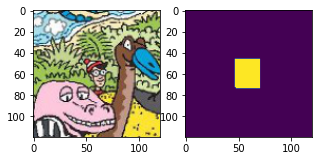

(120, 120, 3)


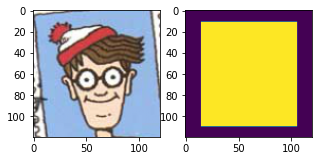

(120, 120, 3)


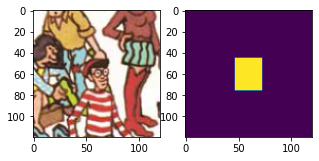

(120, 120, 3)


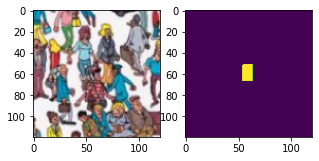

(120, 120, 3)


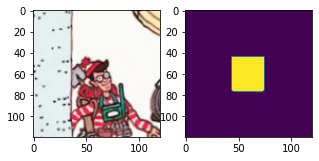

ValueError: ignored

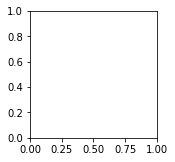

In [30]:
for i, g in zip(dataset_valid.list_patch_positive_img, dataset_valid.list_patch_positive_gt):
  fig = plt.figure(figsize=(5, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(i)
  plt.subplot(1, 2, 2)
  plt.imshow(g)
  print(i.shape)
  plt.show()

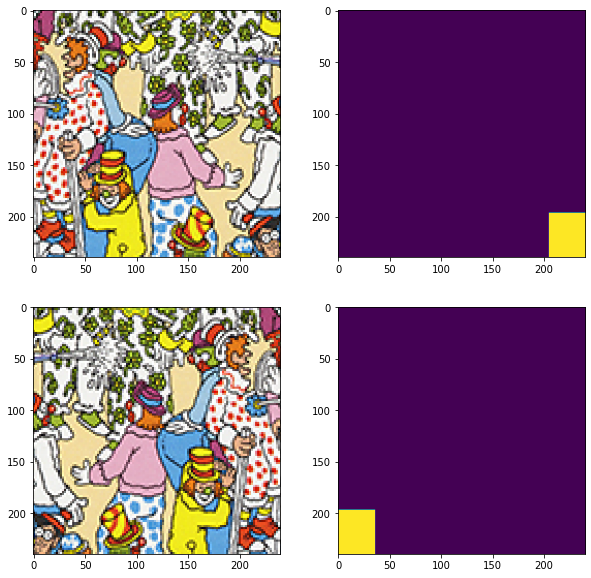

In [ ]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]
flip = Sequence([RandomHorizontalFlip()], probs=1)
sample_flip, sample_gt_flip = flip(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_flip)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_flip)
plt.show()

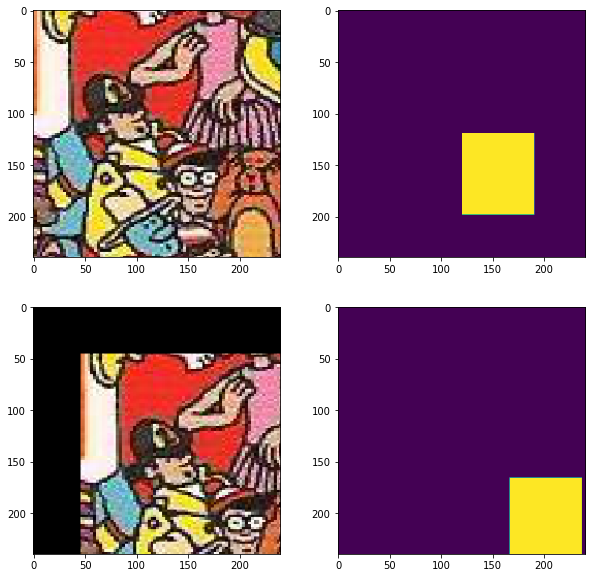

In [ ]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]
translate = Sequence([RandomTranslate(0.2)], probs=1)
sample_translate, sample_gt_translate = translate(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_translate)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_translate)
plt.show()

In [ ]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=size_batch, shuffle=True)

tensor(-6.8435e-09) tensor(1.0000)
tensor([0., 1.], dtype=torch.float64) torch.Size([16, 1, 240, 240]) torch.Size([16, 3, 240, 240])


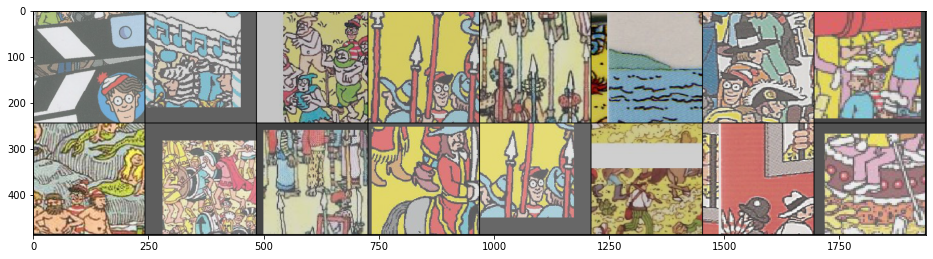

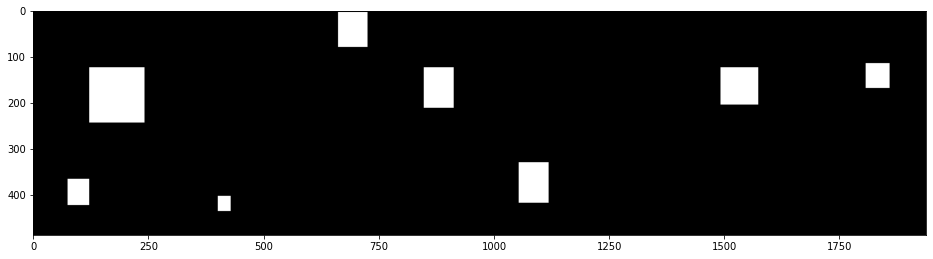

In [ ]:
image_expl, label_expl = iter(loader_train).next()
print(image_expl.mean(), image_expl.std())
print(label_expl.unique(), label_expl.size(), image_expl.size())
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(image_expl, normalize=True))
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(label_expl))

In [ ]:
model = Waldo_UNet(n_channels=3).cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.01)

RuntimeError: ignored

In [ ]:
model_trained = train_model(model,optimizer, loader_train, dataset_validation=loader_valid, n_epoch=n_epoch)

In [ ]:
torch.save(model_trained, fname_trained_model)

TODO: load pre trained model

In [ ]:
from loader import load_image
fname_rdm_test_image = random.choice([os.path.join(path_dataset_folder, "images_test", i) for i in os.listdir(os.path.join(path_dataset_folder, "images_test")) if i.endswith(".jpg")])
image_test = load_image(fname_rdm_test_image)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image_test)
plt.show()

In [ ]:
image_test_resized = resize_image(image_test, size_patch=size_patch)
stack_patch = patchify_test_image(image_test_resized, size_patch)
print(stack_patch.shape)

In [ ]:
image_reconstructed = reconstruct_image_from_patches(image_test_resized, stack_patch, size_patch)
plt.figure(figsize=(20, 20))
plt.imshow(image_reconstructed)
plt.show()

In [ ]:
model_trained.eval()
stack_patch = np.swapaxes(np.swapaxes(stack_patch, 3, 1), 3, 2)
print(stack_patch.shape)
list_pred = []
for i_pred, idx in enumerate(range(0, stack_patch.shape[0], size_batch)):
    tensor_test = torch.from_numpy(stack_patch[i_pred * size_batch : (i_pred + 1) * size_batch, :])
    tensor_test = tensor_test.cuda().float()
    pred = model_trained(tensor_test)
    pred = pred[:, 1:, :, :]
    list_pred.append(np.array(pred))
stack_pred = np.stack(list_pred)

In [ ]:
image_prediction = reconstruct_image_from_patches(image_test_resized, stack_pred, size_patch)
plt.figure(figsize=(20, 20))
plt.imshow(image_reconstructed)
plt.show()